In [32]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


In [2]:
# colourblind-friendly palette from colour universal design (CUD)
# https://jfly.uni-koeln.de/color/
# https://nanx.me/oneclust/reference/cud.html
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())
sns.set_theme(style="whitegrid")

def cud(n: int = len(cud_palette), start: int = 0) -> list[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

In [99]:
# read in the QC files to get full depth of each sample
frames = []
for p in Path("../results/QC/stats/postfilter").rglob("*.csv"):
    df = pd.read_csv(p)
    df["model"] = df["model"].apply(lambda x: x.split("_")[-1].split("@")[0])
    # rename filename column to sample and mean_coverage to depth
    df = df.rename(columns={"filename": "sample", "mean_coverage": "depth"})
    df["mode"] = p.parts[-3]
    frames.append(df)

In [101]:
depth_df = pd.concat(frames)
depth_df.set_index(["sample", "mode", "model"], inplace=True, verify_integrity=True)
depth_df.head()

num_alignments  percent_total_reads  \
sample             mode   model                                        
AJ292__202310      duplex hac              3428                98.45   
AMtb_1__202402     duplex hac              6675                99.70   
ATCC_10708__202309 duplex hac             86304                99.86   
ATCC_17802__202309 duplex hac             34647                99.43   
ATCC_19119__202309 duplex hac             24431                99.13   

                                 yield_gb  depth  yield_gb_gt_25kb    n50  \
sample             mode   model                                             
AJ292__202310      duplex hac        0.02   6.87              0.02  21381   
AMtb_1__202402     duplex hac        0.00   7.06              0.00   5844   
ATCC_10708__202309 duplex hac        0.01  58.34              0.01   4516   
ATCC_17802__202309 duplex hac        0.01  23.90              0.01   5102   
ATCC_19119__202309 duplex hac        0.01  42.64              0.01   8580   

                                  n75  median_length  mean_length  \
sample             mode   model                                     
AJ292__202310      duplex hac    9766         5738.5      10905.0   
AMtb_1__202402     duplex hac    3922         4135.0       4662.0   
ATCC_10708__202309 duplex hac    2221         1992.0       3245.0   
ATCC_17802__202309 duplex hac    2506         2146.0       3550.0   
ATCC_19119__202309 duplex hac    3960         2942.0       5095.0   

                                 median_identity  mean_identity  
sample             mode   model                                  
AJ292__202310      duplex hac              99.79          99.57  
AMtb_1__202402     duplex hac              99.51          99.11  
ATCC_10708__202309 duplex hac              99.79          99.60  
ATCC_17802__202309 duplex hac              99.81          99.63  
ATCC_19119__202309 duplex hac              99.83          99.64

In [173]:
DUPLEX_DP_CAP = 50

frames = []
for p in Path("../results/assess/mutref").rglob("*.precision-recall.tsv"):
    df = pd.read_csv(p, sep="\t")
    sample = p.parent.name
    df["sample"] = sample
    if "without_repetitive_regions" in p.name:
        df["mask_repeats"] = True
    else:
        df["mask_repeats"] = False
    if "illumina" in str(p):
        continue
        # df["caller"] = "illumina"
        # df["depth"] = 100
        # df["mode"] = "simplex"
        # df["version"] = "illumina"
        # df["model"] = "illumina"
    else:
        df["caller"] = p.parts[-7]
        dp = int(p.parts[-6][:-1])
        mode = p.parts[-5]
        model = p.parts[-3].split("_")[-1].split("@")[0]
        full_dp = depth_df.loc[(sample, mode, model), "depth"]
        if full_dp < (dp * 0.9):
            print(f"Skipping {sample} {mode} {model} {full_dp} < {dp}")
            continue
        if mode == "duplex" and model == "fast":
            continue
        if mode == "duplex" and dp > DUPLEX_DP_CAP:
            continue
        df["depth"] = dp
        df["mode"] = mode
        df["version"] = p.parts[-4]
        df["model"] = model
    frames.append(df)
    # duplicate Illumina as duplex also
    if "illumina" in str(p):
        continue
        df2 = df.copy()
        # df2["caller"] = "illumina"
        # df2["depth"] = 100
        # df2["mode"] = "duplex"
        # df2["version"] = "illumina"
        # df2["model"] = "illumina"
        # frames.append(df2)

Skipping AMtb_1__202402 duplex hac 7.06 < 10
Skipping AMtb_1__202402 duplex hac 7.06 < 10
Skipping KPC2__202310 duplex hac 2.71 < 10
Skipping KPC2__202310 duplex hac 2.71 < 10
Skipping AJ292__202310 duplex hac 6.87 < 10
Skipping AJ292__202310 duplex hac 6.87 < 10
Skipping AMtb_1__202402 duplex sup 7.48 < 10
Skipping AMtb_1__202402 duplex sup 7.48 < 10
Skipping KPC2__202310 duplex sup 2.88 < 10
Skipping KPC2__202310 duplex sup 2.88 < 10
Skipping AJ292__202310 duplex sup 7.34 < 10
Skipping AJ292__202310 duplex sup 7.34 < 10
Skipping AMtb_1__202402 duplex fast 4.18 < 10
Skipping AMtb_1__202402 duplex fast 4.18 < 10
Skipping KPC2__202310 duplex fast 2.28 < 10
Skipping KPC2__202310 duplex fast 2.28 < 10
Skipping AJ292__202310 duplex fast 5.68 < 10
Skipping AJ292__202310 duplex fast 5.68 < 10
Skipping AMtb_1__202402 duplex hac 7.06 < 50
Skipping AMtb_1__202402 duplex hac 7.06 < 50
Skipping ATCC_25922__202309 duplex hac 34.96 < 50
Skipping ATCC_25922__202309 duplex hac 34.96 < 50
Skipping MMC

In [174]:
pr_df = pd.concat(frames)
pr_df.reset_index(inplace=True, drop=True)
# drop all columns except thw following
keep_cols = [
    "MIN_QUAL",
    "PREC",
    "RECALL",
    "F1_SCORE",
    "VAR_TYPE",
    "sample",
    "mask_repeats",
    "caller",
    "depth",
    "mode",
    "version",
    "model",
]
pr_df = pr_df[keep_cols]
pr_df.head()

MIN_QUAL      PREC    RECALL  F1_SCORE VAR_TYPE              sample  \
0         0  0.997591  0.998072  0.997831      SNP  ATCC_35897__202309   
1         1  0.997591  0.998072  0.997831      SNP  ATCC_35897__202309   
2         2  0.997591  0.998072  0.997831      SNP  ATCC_35897__202309   
3         3  0.997591  0.998072  0.997831      SNP  ATCC_35897__202309   
4         4  0.997591  0.998072  0.997831      SNP  ATCC_35897__202309   

   mask_repeats      caller  depth    mode version model  
0          True  nanocaller     10  duplex  v4.3.0   hac  
1          True  nanocaller     10  duplex  v4.3.0   hac  
2          True  nanocaller     10  duplex  v4.3.0   hac  
3          True  nanocaller     10  duplex  v4.3.0   hac  
4          True  nanocaller     10  duplex  v4.3.0   hac

In [177]:
x = "depth"
y = "value"
hue = "caller"
col = "model"
row = "metric"

In [178]:
best_ix = (
    pr_df.query("not mask_repeats")
    .groupby([x, hue, col, "sample", "VAR_TYPE", "mode"])["F1_SCORE"]
    .idxmax()
)
best_df = pr_df.iloc[best_ix]
best_df = best_df.melt(
    id_vars=keep_cols[4:],
    value_vars=["PREC", "RECALL", "F1_SCORE"],
    var_name="metric",
    value_name="value",
)
# rename the values to be more descriptive
best_df["metric"] = best_df["metric"].replace(
    {"PREC": "Precision", "RECALL": "Recall", "F1_SCORE": "F1 Score"}
)

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/3618581463.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[y] = d[y].apply(lambda v: cap if v == 1.0 else v)
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/3618581463.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[y] = d[y].apply(lambda v: cap if v == 1.0 else v)
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/3618581463.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

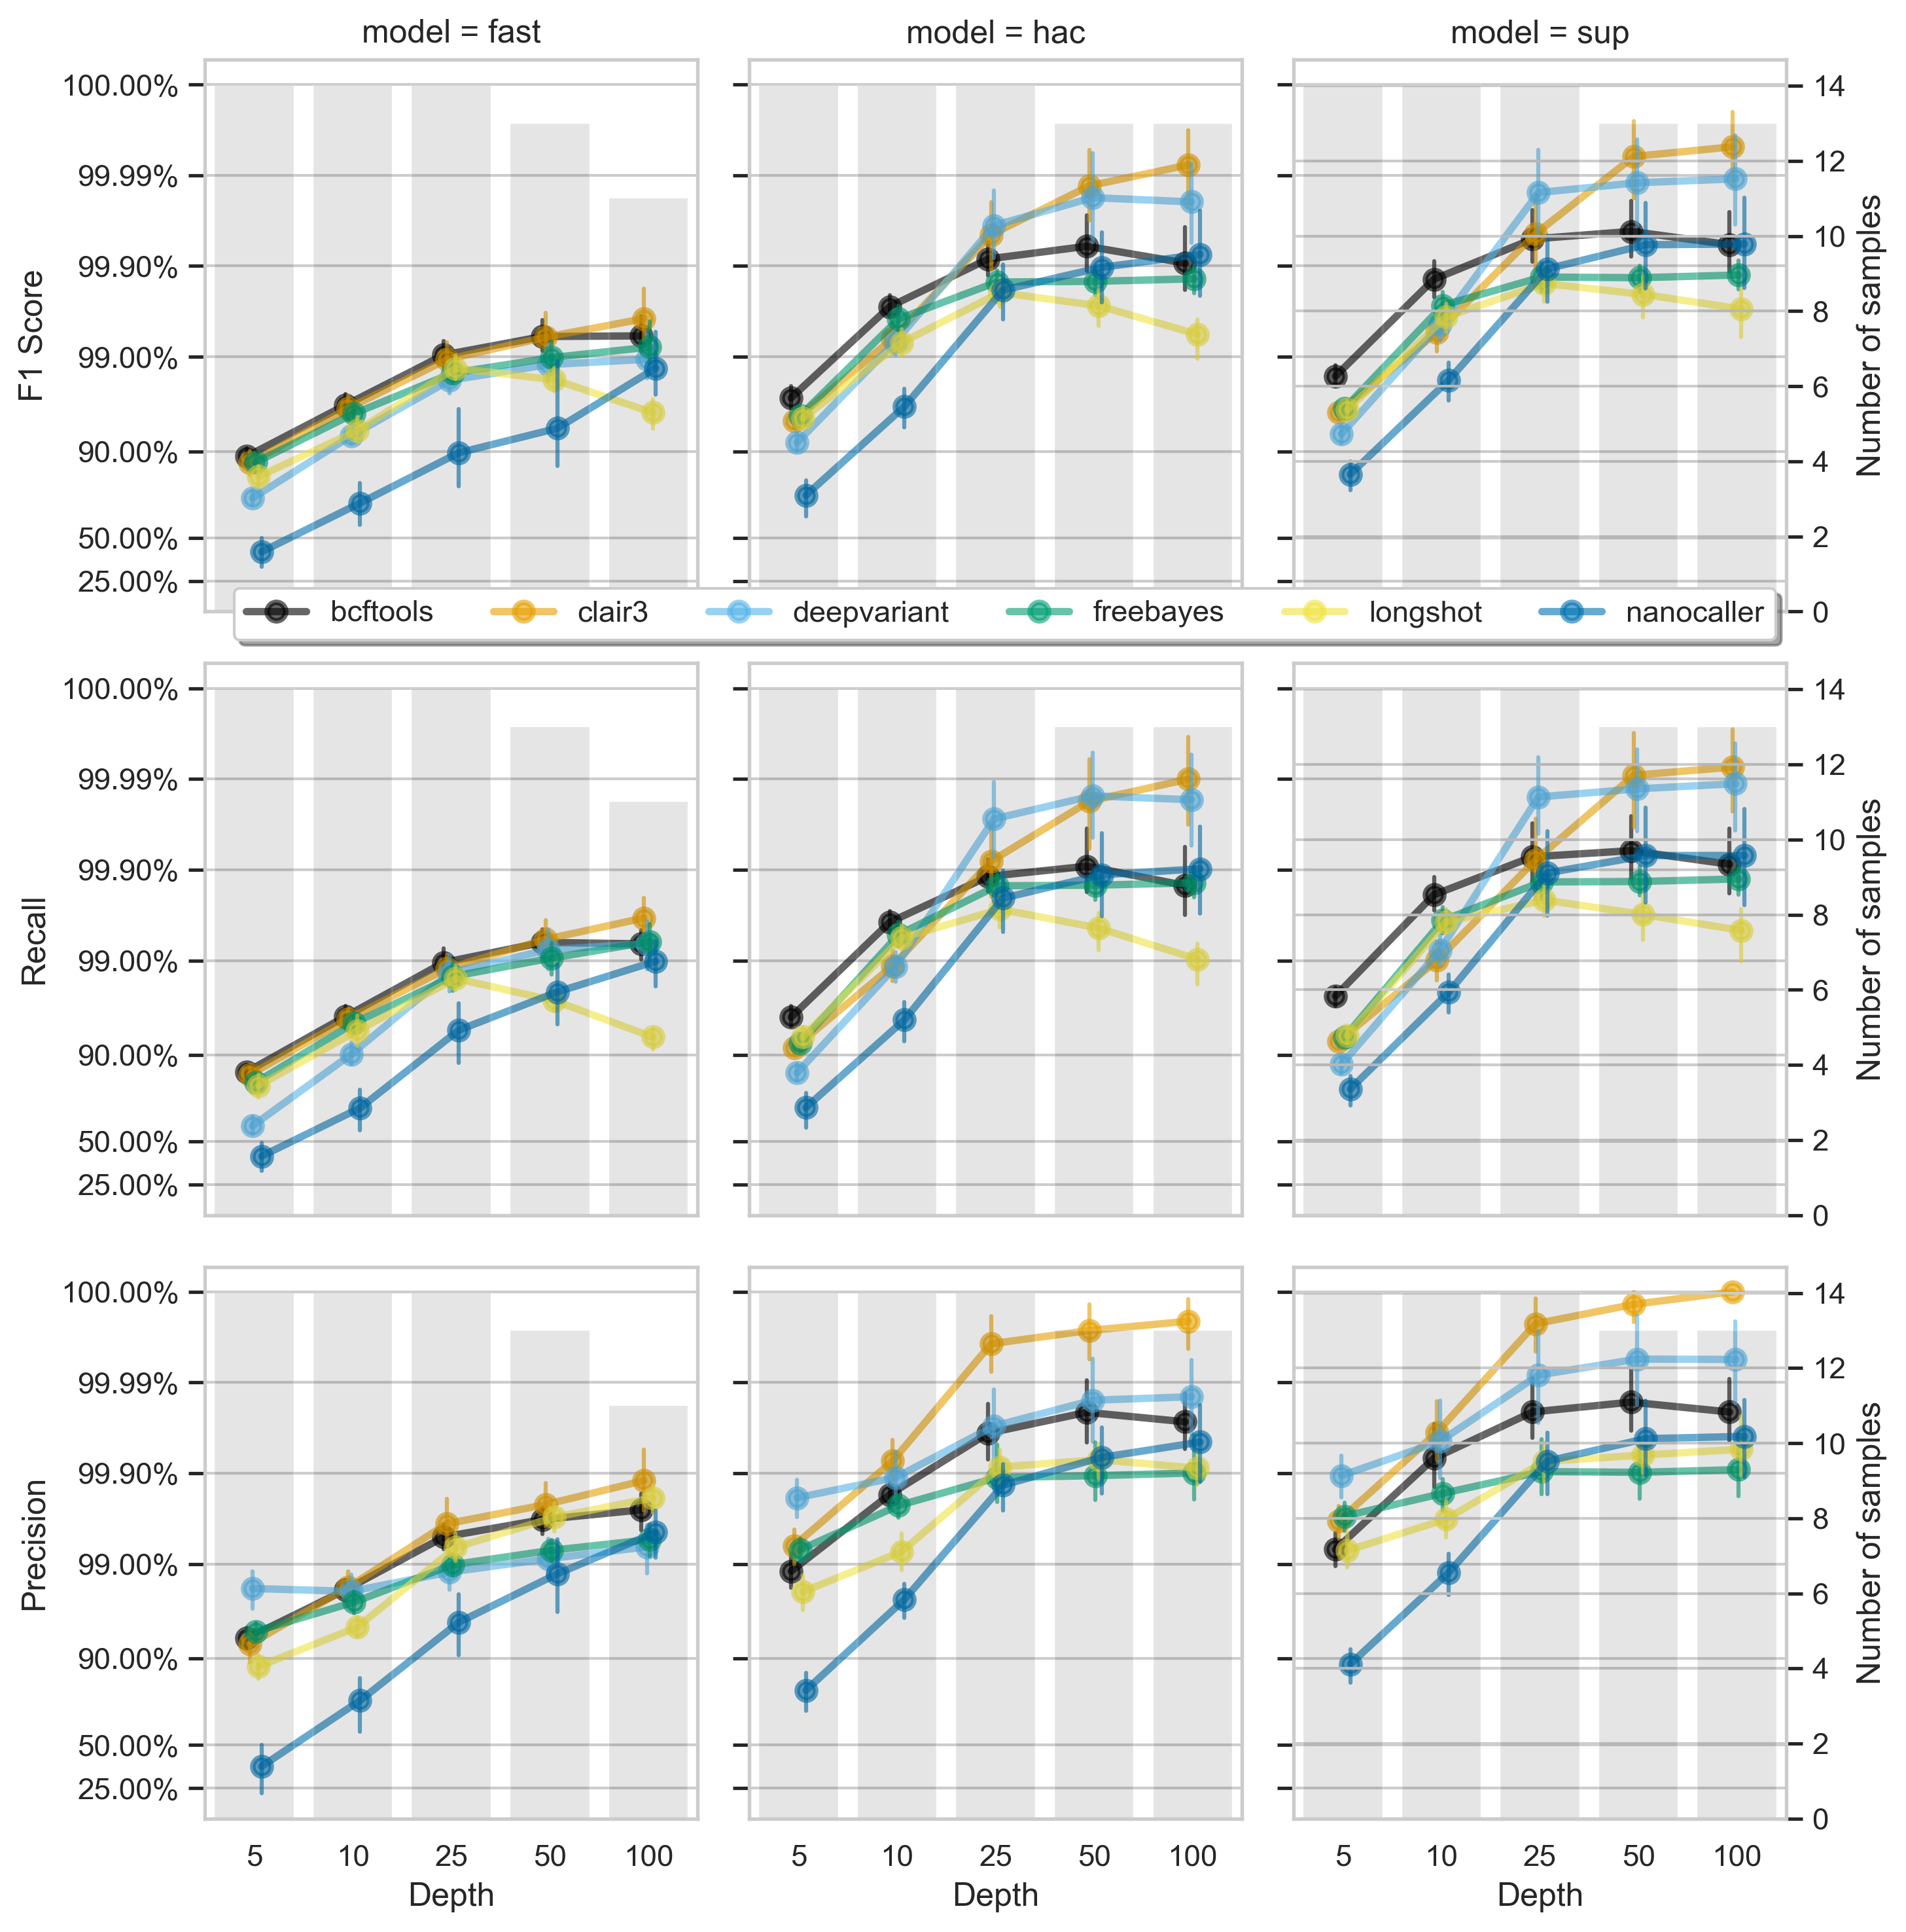

In [179]:
vartype = "SNP"
mode = "simplex"
data = best_df.query(f"VAR_TYPE == '{vartype}' and mode == '{mode}'")
palette = cud(n=len(data[hue].unique()))
# palette = "colorblind"
row_order = ["F1 Score", "Recall", "Precision"]
ncols = len(data[col].unique())
nrows = len(row_order)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(10, 10), dpi=300, sharey=True, sharex=True
)
legend = True
i = 0
for metric in row_order:
    for model in data[col].unique():

        d = data.query(f"{col} == '{model}' and metric == '{metric}'")
        # transform precision so logit shows values of 1.0 - i.e. change values of 1.0 to 0.99999
        cap = 0.99999
        d[y] = d[y].apply(lambda v: cap if v == 1.0 else v)
        ax = axes.flatten()[i]
        sns.pointplot(
            ax=ax,
            data=d,
            x=x,
            y=y,
            hue=hue,
            palette=palette,
            units="sample",
            dodge=True,
            legend=legend,
            alpha=0.6,
            err_kws={"linewidth": 1.5, "alpha": 0.6},
        )

        if i < ncols:
            ax.set_title(f"model = {model}")
        # if i % nrows == 0:
            # add metric label to the right
            # ax.set_ylabel(
                # metric,
                # rotation=270,
                # labelpad=15,
                # fontdict={"fontsize": 12, "fontweight": "bold"},
            # )
            # ax.yaxis.get_label().set_visible(True)
            # ax.yaxis.set_label_position("right")
            # move label to top of axis
            # ax.yaxis.set_label_coords(1.2, 0.9)
        # else:
        #     ax.set_ylabel("")
        ax.set_ylabel(metric)

        ax.set_xlabel("Depth")

        ax.set_yscale("logit", nonpositive="clip")
        yticks = [0.25, 0.5, 0.9, 0.99, 0.999, 0.9999, cap]
        yticklabels = [f"{yval:.2%}" for yval in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        if legend:
            handles, labels = ax.get_legend_handles_labels()
            legend = False
            ax.legend().remove()

        # plot the number of sample at each depth
        ax2 = ax.twinx()
        xs = []
        ys = []
        for depth in d[x].unique():
            count = d.query(f"{x} == {depth}")["sample"].nunique()
            xs.append(depth)
            ys.append(count)

        sns.barplot(x=xs, y=ys, ax=ax2, color="black", alpha=0.1)
        if (i + 1) % ncols == 0:
            ax2.set_ylabel("Number of samples")
        else:
            ax2.set(yticks=[], ylabel="", yticklabels=[])

        # get rid of all minor y-axis ticks
        ax.yaxis.set_minor_locator(plt.NullLocator())
        i += 1

plt.tight_layout()
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    bbox_to_anchor=(0.52, 0.7),
    ncol=len(data[hue].unique()),
    title="",
    framealpha=1.0,
    fancybox=True,
    shadow=True,
)

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/1627818159.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[y] = d[y].apply(lambda v: cap if v == 1.0 else v)
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/1627818159.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[y] = d[y].apply(lambda v: cap if v == 1.0 else v)
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/1627818159.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

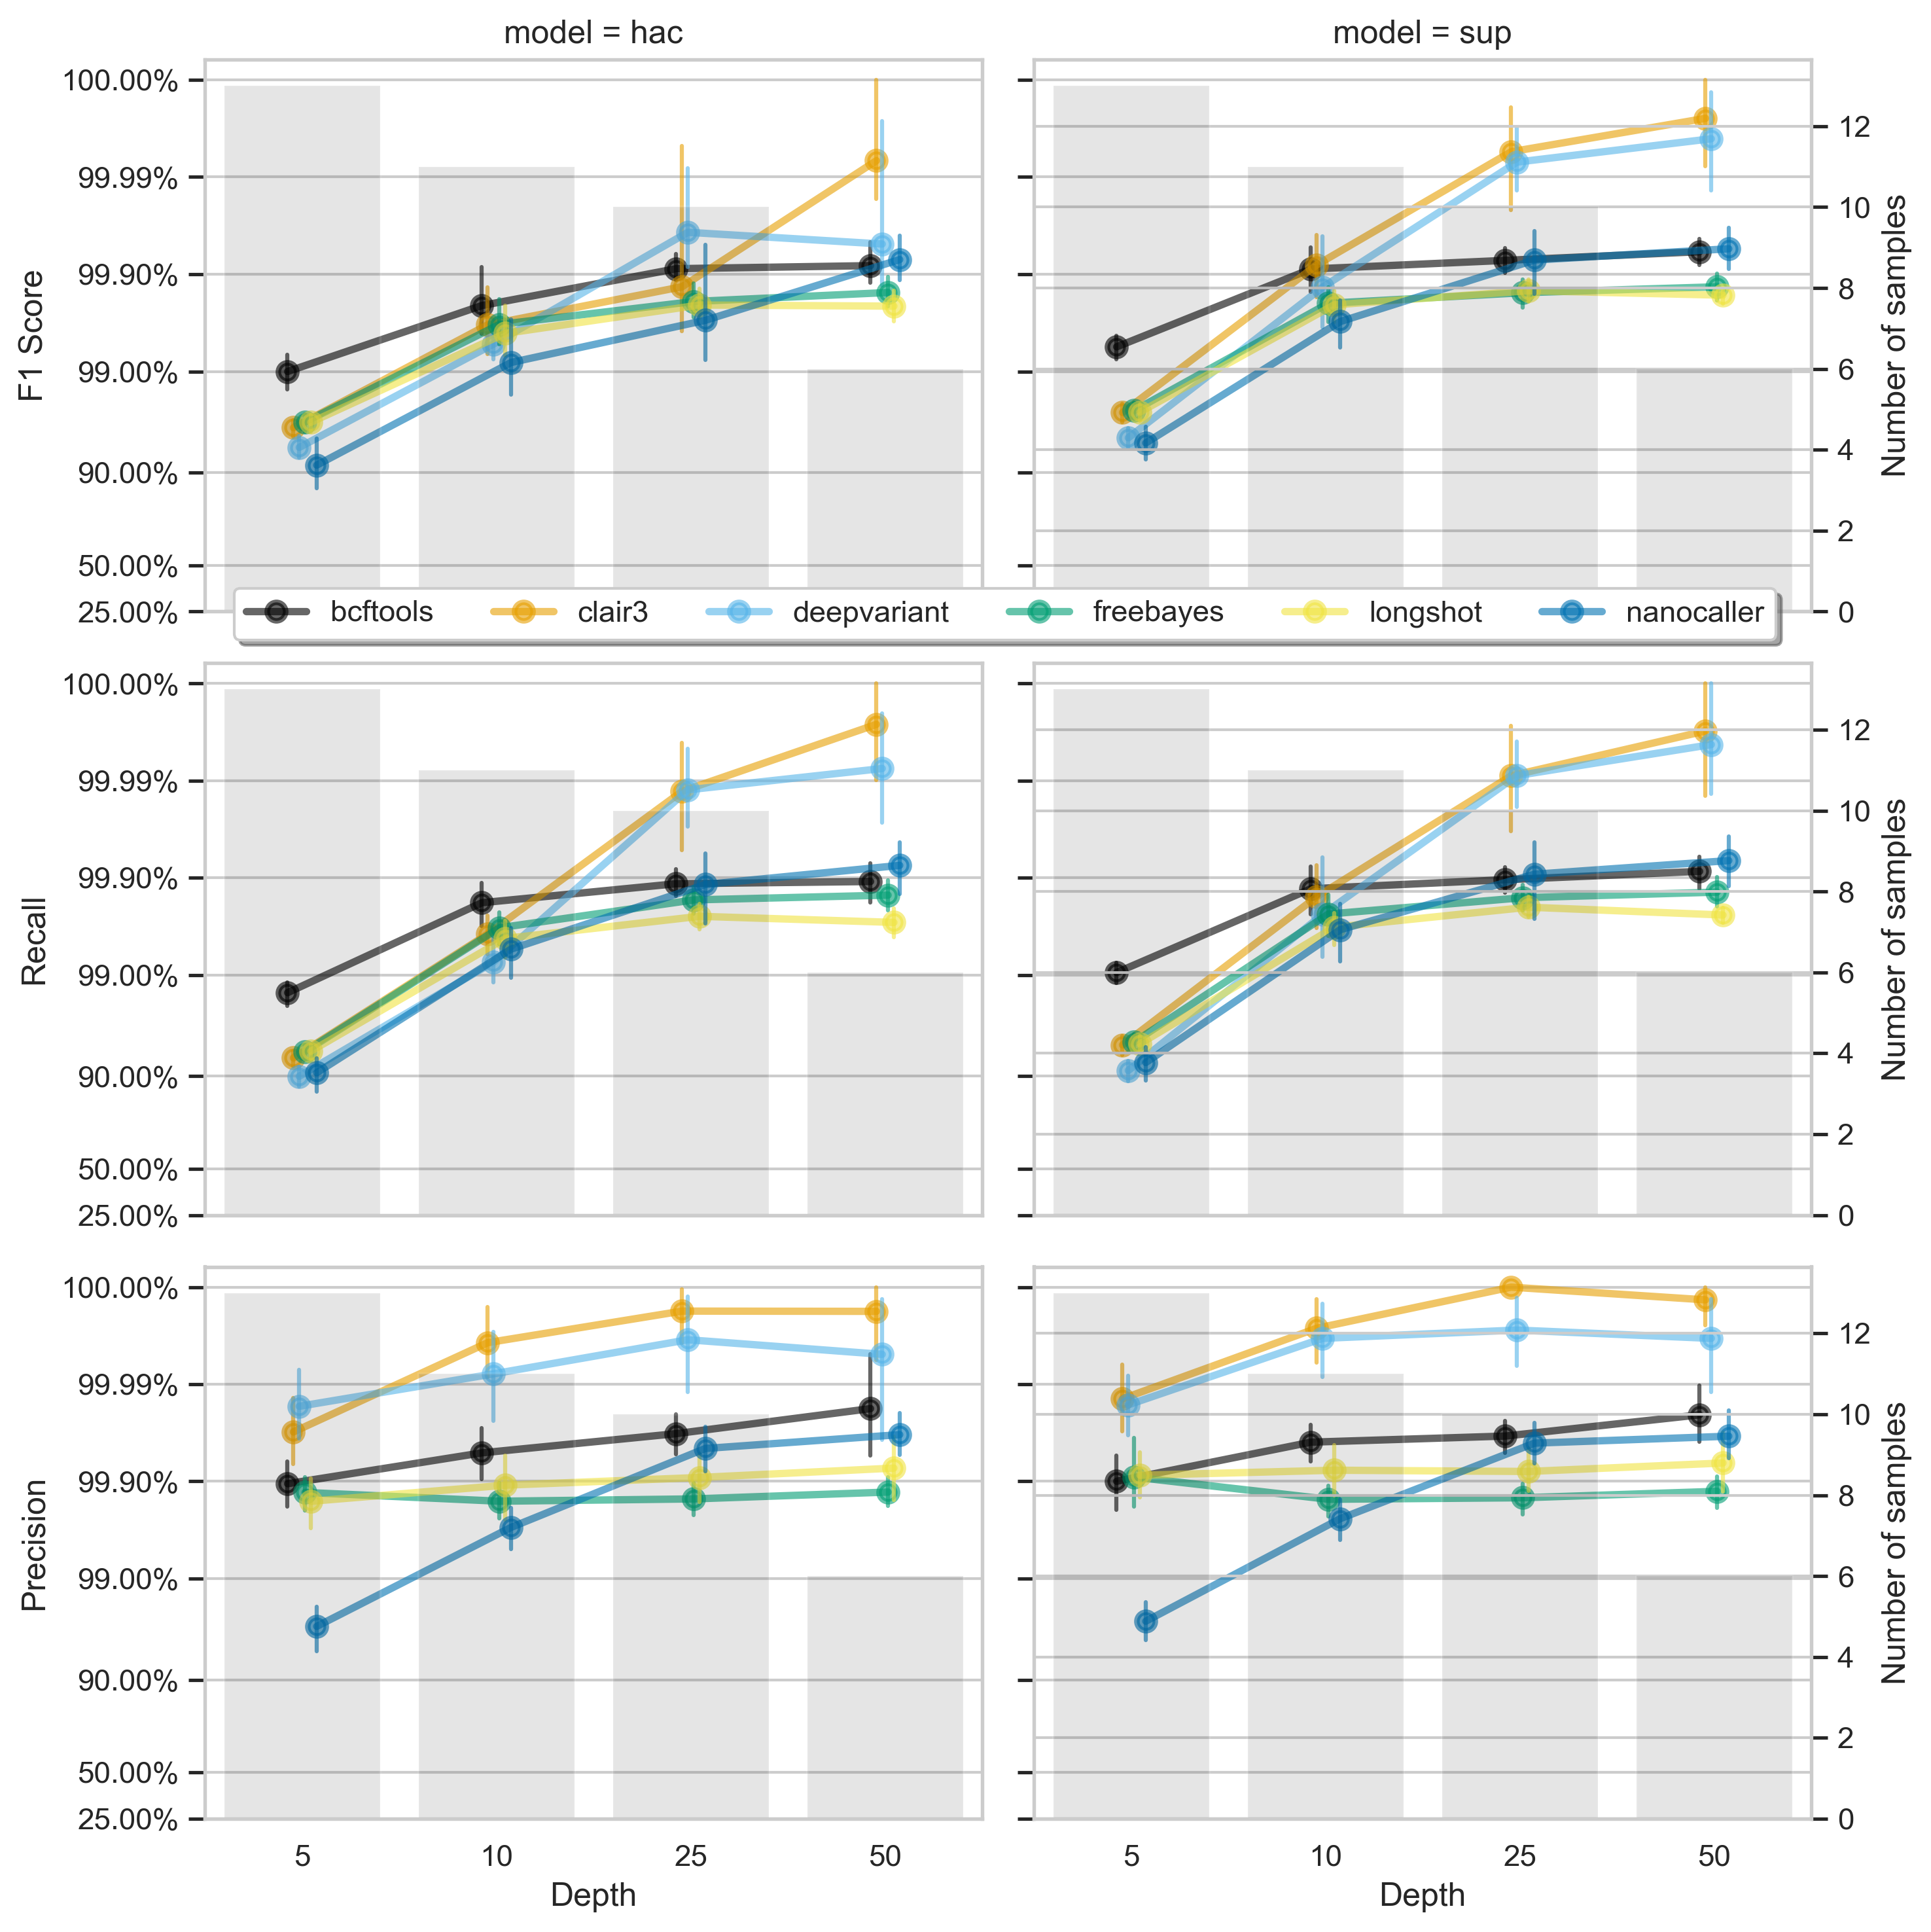

In [180]:
vartype = "SNP"
mode = "duplex"
data = best_df.query(f"VAR_TYPE == '{vartype}' and mode == '{mode}'")
palette = cud(n=len(data[hue].unique()))
# palette = "colorblind"
row_order = ["F1 Score", "Recall", "Precision"]
ncols = len(data[col].unique())
nrows = len(row_order)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(10, 10), dpi=300, sharey=True, sharex=True
)
legend = True
i = 0
for metric in row_order:
    for model in data[col].unique():

        d = data.query(f"{col} == '{model}' and metric == '{metric}'")
        # transform precision so logit shows values of 1.0 - i.e. change values of 1.0 to 0.99999
        cap = 0.99999
        d[y] = d[y].apply(lambda v: cap if v == 1.0 else v)
        ax = axes.flatten()[i]
        sns.pointplot(
            ax=ax,
            data=d,
            x=x,
            y=y,
            hue=hue,
            palette=palette,
            units="sample",
            dodge=True,
            legend=legend,
            alpha=0.6,
            err_kws={"linewidth": 1.5, "alpha": 0.6},
        )

        if i < ncols:
            ax.set_title(f"model = {model}")
        # if i % nrows == 0:
            # add metric label to the right
            # ax.set_ylabel(
                # metric,
                # rotation=270,
                # labelpad=15,
                # fontdict={"fontsize": 12, "fontweight": "bold"},
            # )
            # ax.yaxis.get_label().set_visible(True)
            # ax.yaxis.set_label_position("right")
            # move label to top of axis
            # ax.yaxis.set_label_coords(1.2, 0.9)
        # else:
        #     ax.set_ylabel("")
        ax.set_ylabel(metric)

        ax.set_xlabel("Depth")

        ax.set_yscale("logit", nonpositive="clip")
        # yticks = [0.5, 0.9, 0.99, 0.999, 0.9999, cap]
        # yticklabels = [f"{yval:.2%}" for yval in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        if legend:
            handles, labels = ax.get_legend_handles_labels()
            legend = False
            ax.legend().remove()

        # plot the number of sample at each depth
        ax2 = ax.twinx()
        xs = []
        ys = []
        for depth in d[x].unique():
            count = d.query(f"{x} == {depth}")["sample"].nunique()
            xs.append(depth)
            ys.append(count)

        sns.barplot(x=xs, y=ys, ax=ax2, color="black", alpha=0.1)
        if (i + 1) % ncols == 0:
            ax2.set_ylabel("Number of samples")
        else:
            ax2.set(yticks=[], ylabel="", yticklabels=[])

        # get rid of all minor y-axis ticks
        ax.yaxis.set_minor_locator(plt.NullLocator())
        i += 1

plt.tight_layout()
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    bbox_to_anchor=(0.52, 0.7),
    ncol=len(data[hue].unique()),
    title="",
    framealpha=1.0,
    fancybox=True,
    shadow=True,
)

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/3601093679.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[y] = d[y].apply(lambda v: cap if v == 1.0 else v)
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/3601093679.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[y] = d[y].apply(lambda v: low_cap if v == 0.0 else v)
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/3601093679.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy 

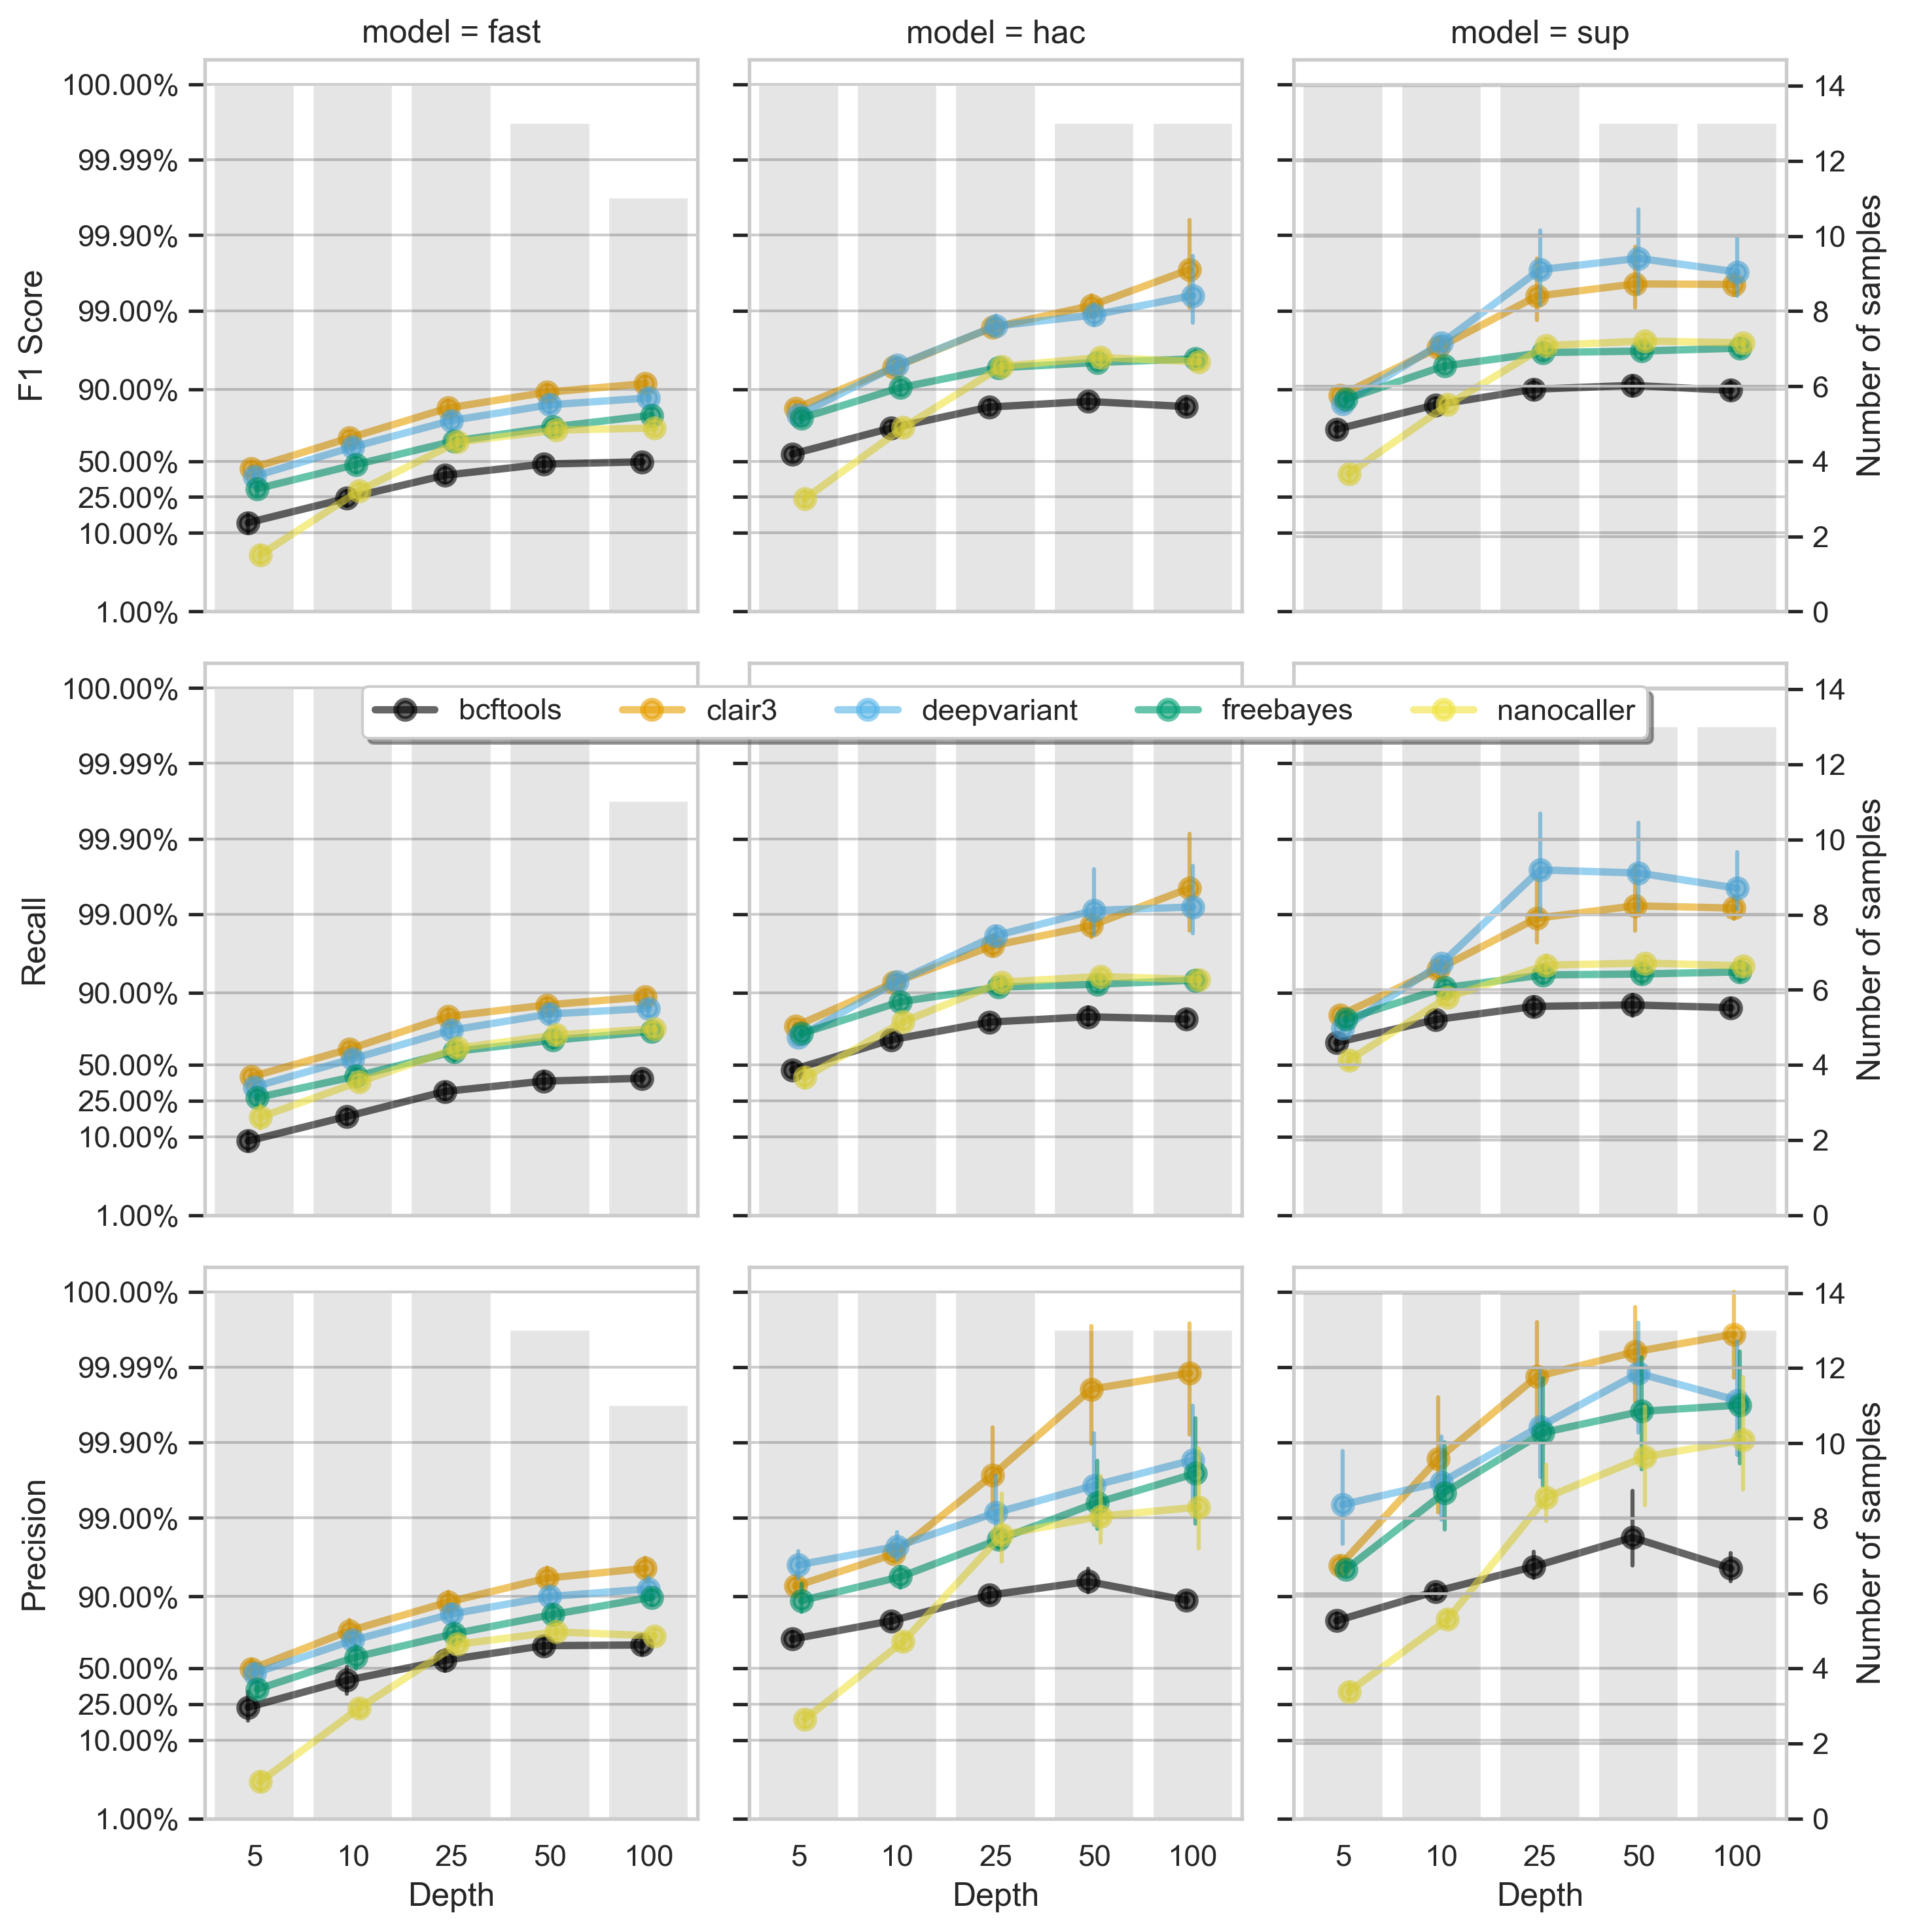

In [181]:
vartype = "INDEL"
mode = "simplex"
data = best_df.query(f"VAR_TYPE == '{vartype}' and mode == '{mode}' and caller != 'longshot'")
palette = cud(n=len(data[hue].unique()))
# palette = "colorblind"
row_order = ["F1 Score", "Recall", "Precision"]
ncols = len(data[col].unique())
nrows = len(row_order)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(10, 10), dpi=300, sharey=True, sharex=True
)
legend = True
i = 0
for metric in row_order:
    for model in data[col].unique():

        d = data.query(f"{col} == '{model}' and metric == '{metric}'")
        # transform precision so logit shows values of 1.0 - i.e. change values of 1.0 to 0.99999
        cap = 0.99999
        d[y] = d[y].apply(lambda v: cap if v == 1.0 else v)
        low_cap = 0.001
        d[y] = d[y].apply(lambda v: low_cap if v == 0.0 else v)
        ax = axes.flatten()[i]
        sns.pointplot(
            ax=ax,
            data=d,
            x=x,
            y=y,
            hue=hue,
            palette=palette,
            units="sample",
            dodge=True,
            legend=legend,
            alpha=0.6,
            err_kws={"linewidth": 1.5, "alpha": 0.6},
        )

        if i < ncols:
            ax.set_title(f"model = {model}")
        # if i % nrows == 0:
            # add metric label to the right
            # ax.set_ylabel(
                # metric,
                # rotation=270,
                # labelpad=15,
                # fontdict={"fontsize": 12, "fontweight": "bold"},
            # )
            # ax.yaxis.get_label().set_visible(True)
            # ax.yaxis.set_label_position("right")
            # move label to top of axis
            # ax.yaxis.set_label_coords(1.2, 0.9)
        # else:
        #     ax.set_ylabel("")
        ax.set_ylabel(metric)

        ax.set_xlabel("Depth")

        ax.set_yscale("logit", nonpositive="clip")
        yticks = [0.01, 0.1, 0.25, 0.5, 0.9, 0.99, 0.999, 0.9999, cap]
        yticklabels = [f"{yval:.2%}" if yval != low_cap else "0.00%" for yval in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        if legend:
            handles, labels = ax.get_legend_handles_labels()
            legend = False
            ax.legend().remove()

        # plot the number of sample at each depth
        ax2 = ax.twinx()
        xs = []
        ys = []
        for depth in d[x].unique():
            count = d.query(f"{x} == {depth}")["sample"].nunique()
            xs.append(depth)
            ys.append(count)

        sns.barplot(x=xs, y=ys, ax=ax2, color="black", alpha=0.1)
        if (i + 1) % ncols == 0:
            ax2.set_ylabel("Number of samples")
        else:
            ax2.set(yticks=[], ylabel="", yticklabels=[])

        # get rid of all minor y-axis ticks
        ax.yaxis.set_minor_locator(plt.NullLocator())
        i += 1

plt.tight_layout()
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    bbox_to_anchor=(0.52, 0.65),
    ncol=len(data[hue].unique()),
    title="",
    framealpha=1.0,
    fancybox=True,
    shadow=True,
)

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/1302386646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[y] = d[y].apply(lambda v: cap if v == 1.0 else v)
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/1302386646.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[y] = d[y].apply(lambda v: low_cap if v == 0.0 else v)
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_42818/1302386646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy 

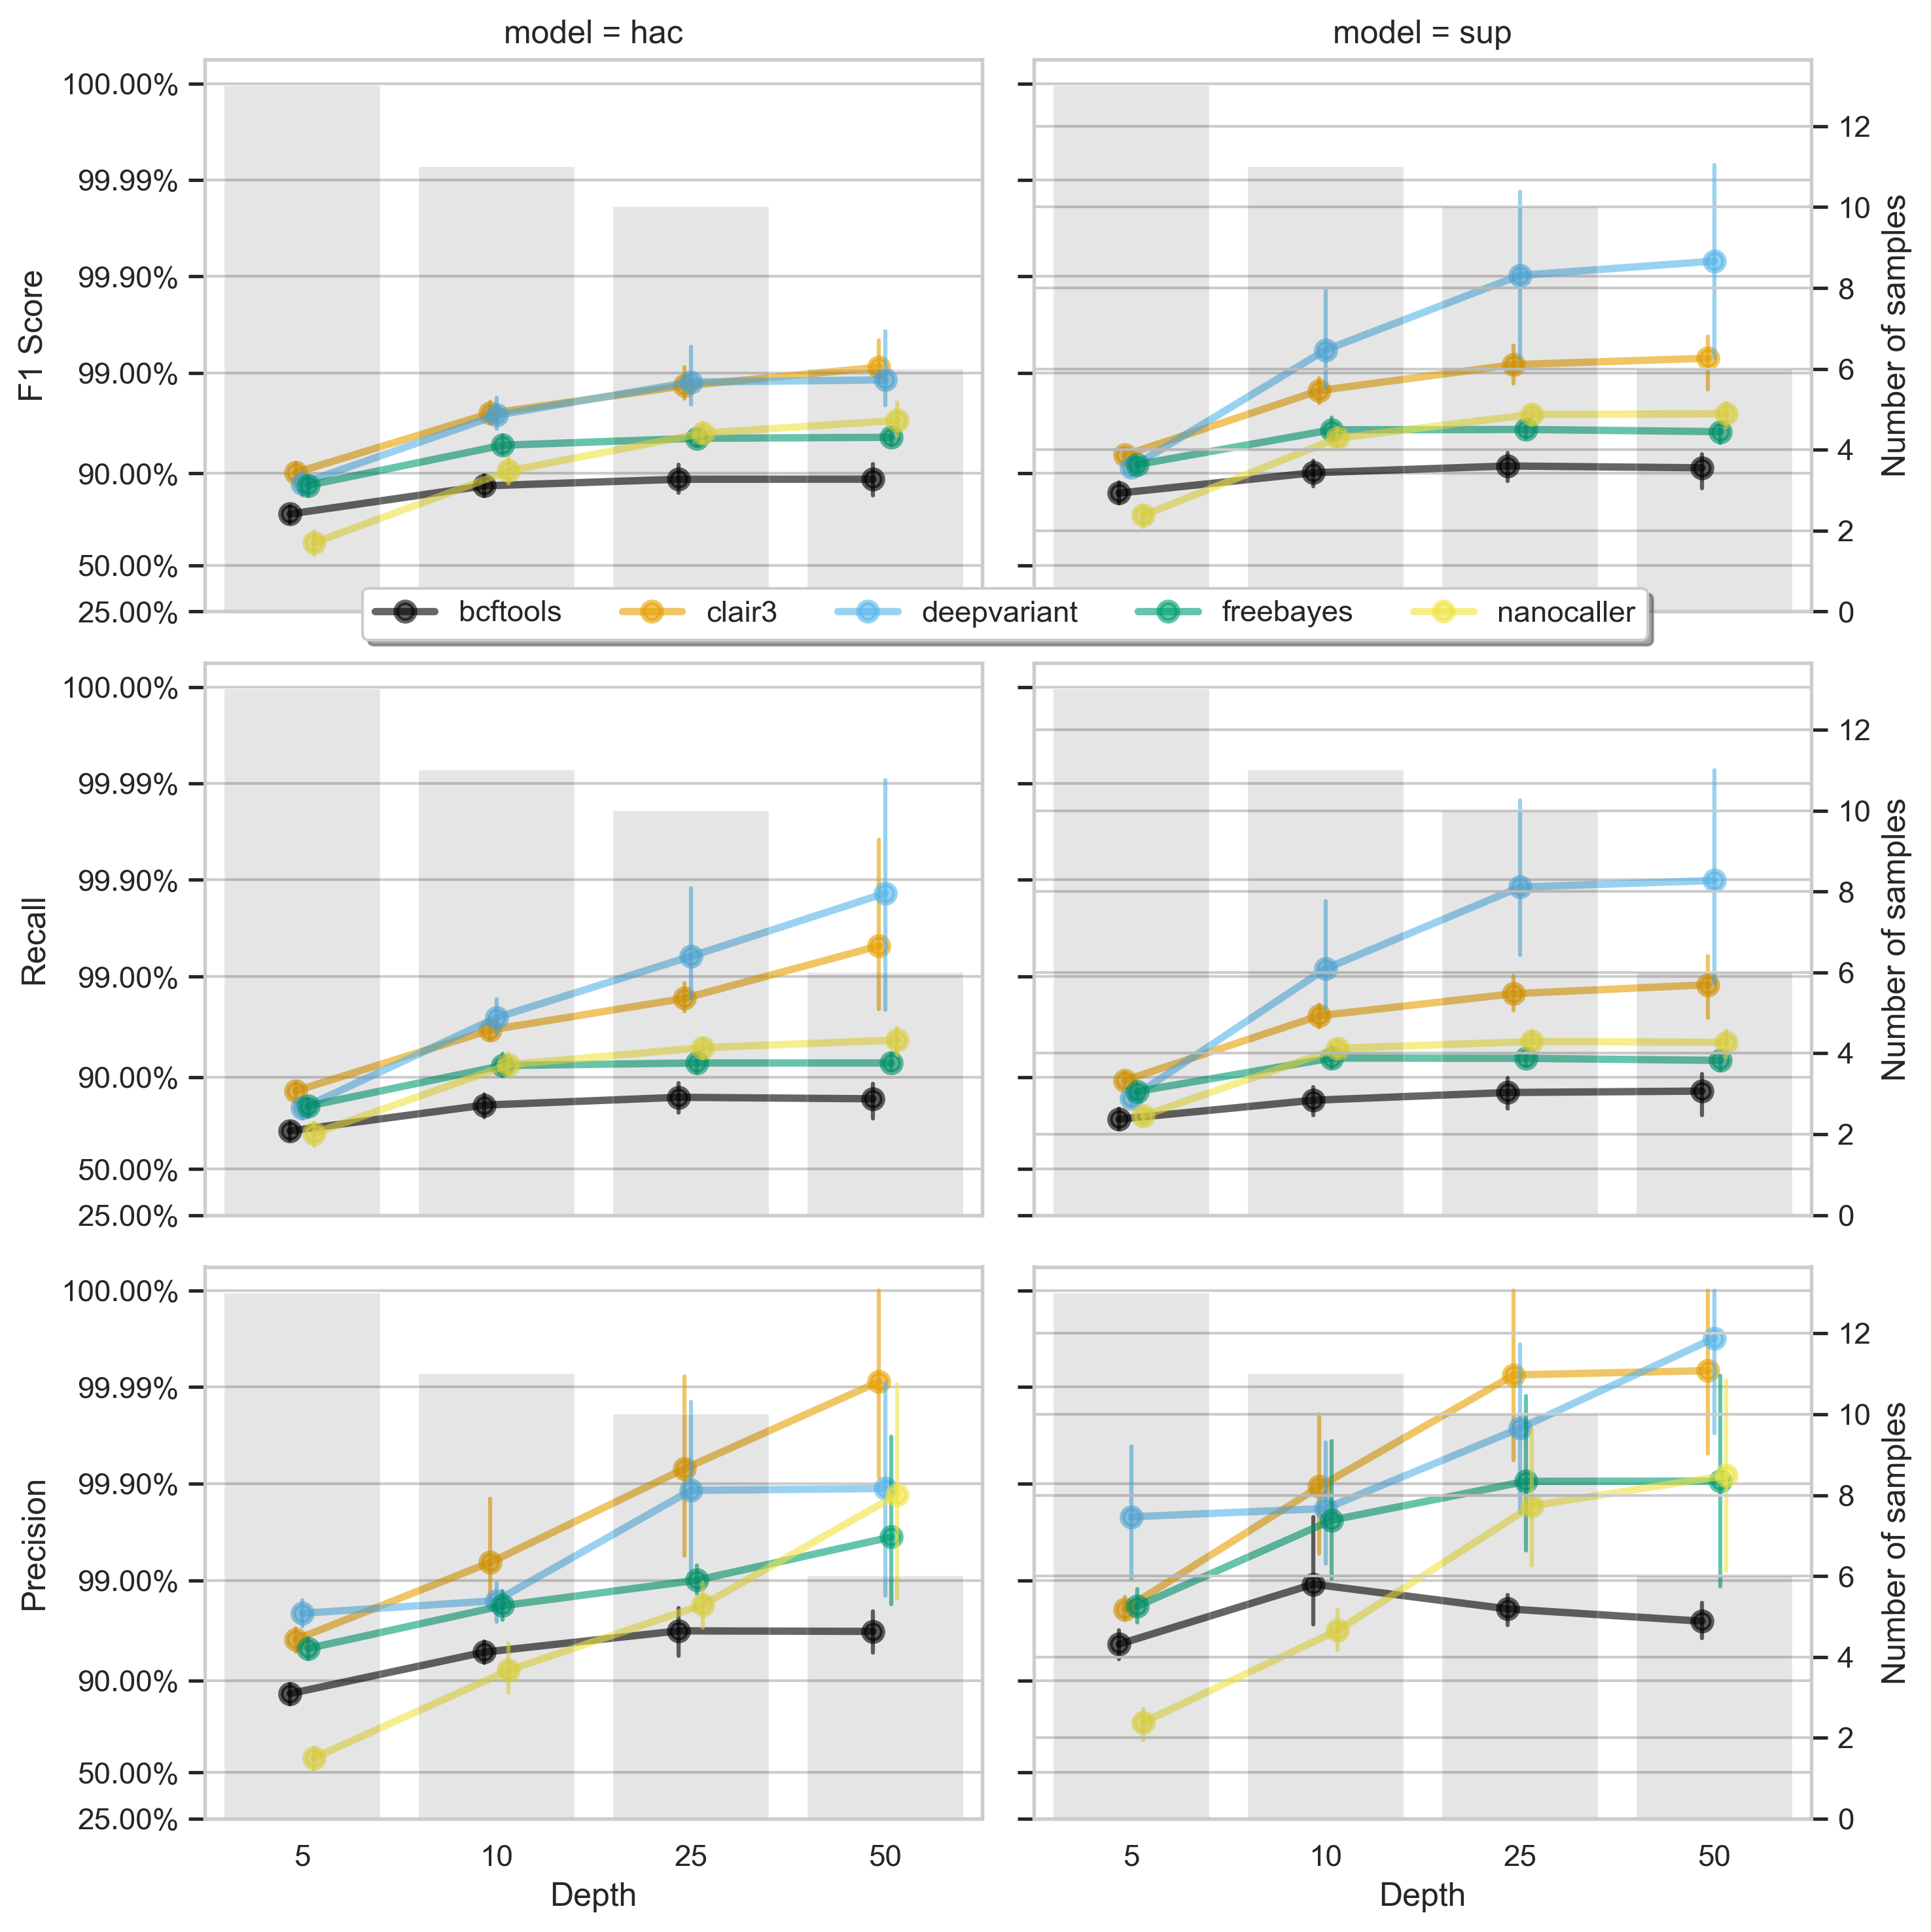

In [182]:
vartype = "INDEL"
mode = "duplex"
data = best_df.query(f"VAR_TYPE == '{vartype}' and mode == '{mode}' and caller != 'longshot'")
palette = cud(n=len(data[hue].unique()))
# palette = "colorblind"
row_order = ["F1 Score", "Recall", "Precision"]
ncols = len(data[col].unique())
nrows = len(row_order)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(10, 10), dpi=300, sharey=True, sharex=True
)
legend = True
i = 0
for metric in row_order:
    for model in data[col].unique():

        d = data.query(f"{col} == '{model}' and metric == '{metric}'")
        # transform precision so logit shows values of 1.0 - i.e. change values of 1.0 to 0.99999
        cap = 0.99999
        d[y] = d[y].apply(lambda v: cap if v == 1.0 else v)
        low_cap = 0.001
        d[y] = d[y].apply(lambda v: low_cap if v == 0.0 else v)
        ax = axes.flatten()[i]
        sns.pointplot(
            ax=ax,
            data=d,
            x=x,
            y=y,
            hue=hue,
            palette=palette,
            units="sample",
            dodge=True,
            legend=legend,
            alpha=0.6,
            err_kws={"linewidth": 1.5, "alpha": 0.6},
        )

        if i < ncols:
            ax.set_title(f"model = {model}")
        # if i % nrows == 0:
            # add metric label to the right
            # ax.set_ylabel(
                # metric,
                # rotation=270,
                # labelpad=15,
                # fontdict={"fontsize": 12, "fontweight": "bold"},
            # )
            # ax.yaxis.get_label().set_visible(True)
            # ax.yaxis.set_label_position("right")
            # move label to top of axis
            # ax.yaxis.set_label_coords(1.2, 0.9)
        # else:
        #     ax.set_ylabel("")
        ax.set_ylabel(metric)

        ax.set_xlabel("Depth")

        ax.set_yscale("logit", nonpositive="clip")
        yticks = [0.25, 0.5, 0.9, 0.99, 0.999, 0.9999, cap]
        yticklabels = [f"{yval:.2%}" if yval != low_cap else "0.00%" for yval in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        if legend:
            handles, labels = ax.get_legend_handles_labels()
            legend = False
            ax.legend().remove()

        # plot the number of sample at each depth
        ax2 = ax.twinx()
        xs = []
        ys = []
        for depth in d[x].unique():
            count = d.query(f"{x} == {depth}")["sample"].nunique()
            xs.append(depth)
            ys.append(count)

        sns.barplot(x=xs, y=ys, ax=ax2, color="black", alpha=0.1)
        if (i + 1) % ncols == 0:
            ax2.set_ylabel("Number of samples")
        else:
            ax2.set(yticks=[], ylabel="", yticklabels=[])

        # get rid of all minor y-axis ticks
        ax.yaxis.set_minor_locator(plt.NullLocator())
        i += 1

plt.tight_layout()
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    bbox_to_anchor=(0.52, 0.7),
    ncol=len(data[hue].unique()),
    title="",
    framealpha=1.0,
    fancybox=True,
    shadow=True,
)